In [13]:

from torch.nn import functional as F

from PIL import Image
from glob import glob
from scipy.io import loadmat

import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as data
import torchvision.transforms.functional as FF

import torch
import torchvision
import os
import random

import seaborn as sns

#### Load the data

In [23]:
class Crowd(data.Dataset):
    def __init__(self, root_path, trans):
        self.root_path = root_path
        self.trans = trans
        self.im_list = sorted(glob(os.path.join(self.root_path, '*.jpg')))
        self.annot_list = sorted(glob(os.path.join(self.root_path, '*.mat')))
        print('number of img: {}'.format(len(self.im_list))) 
        
        plt.hist(([len(loadmat(annot)['annPoints']) for annot in self.annot_list]), bins=24)

    def __len__(self):
        return len(self.im_list)

    def __getitem__(self, item):
        img_path = self.im_list[item]
        ann_path = img_path.replace('.jpg', '_ann.mat')
        img = self.train_transform(Image.open(img_path).convert('RGB'))
        keypoints = loadmat(ann_path)['annPoints']
        img = self.trans(img)
        
        if len(keypoints) < 300:
            c = 0
        elif len(keypoints) < 700:
            c = 1
        elif len(keypoints) < 1200:
            c = 2
        elif len(keypoints) < 2300:
            c = 3
        else:
            c = 4

        return img, c

    def train_transform(self, img):
        img = FF.resize(img, (224,224))
        return img

In [7]:
annot_list = sorted(glob(os.path.join('data/Train', '*.mat')))
labels = [len(loadmat(annot)['annPoints']) for annot in annot_list]
l = [0 if x < 300 else (1 if x < 700 else(2 if x < 1200 else (3 if x < 2300 else 4))) for x in labels]

[1,
 0,
 0,
 0,
 1,
 3,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 4,
 4,
 4,
 1,
 3,
 1,
 1,
 0,
 1,
 4,
 2,
 3,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 3,
 1,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 3,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 3,
 1,
 1,
 4,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 3,
 1,
 1,
 0,
 0,
 2,
 0,
 3,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 4,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 4,
 1,
 3,
 4,
 0,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 3,
 0,
 0,
 1,
 4,
 1,
 1,
 0,
 1,
 1,
 0,
 3,
 3,
 0,
 0,
 0,
 2,
 0,


/Users/luismiguel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


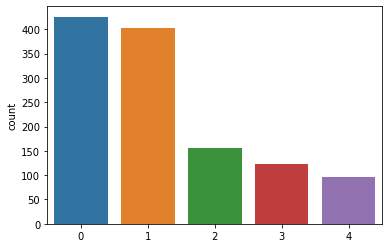

In [14]:
sns.countplot(l)

number of img: 1201
number of img: 334


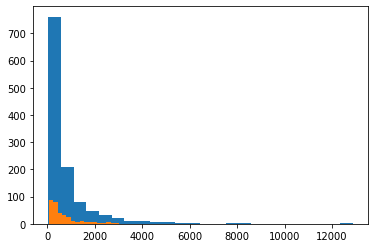

In [21]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
batch_size = 2500
learning_rate = 0.001
downsample_ratio=8

pad_size = 9999

transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_dataset = Crowd('data/Train/', transformation)
test_dataset = Crowd('data/Test/', transformation)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

#### Build the Model

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        # -> n, 3, 224, 224
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 110, 110
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 53, 53
        x = x.view(-1, 16 * 53 * 53)            # -> n, 44944
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 12816
        return x

#### Training Loop

In [5]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

torch.Size([1201])
loss
torch.Size([1201])
loss
torch.Size([1201])
loss
torch.Size([1201])
loss
torch.Size([1201])
loss
Finished Training


#### Testing Loop

In [43]:
# load pre-trained model
model = ConvNet()
model.load_state_dict(torch.load(PATH))
model.eval()

n_labels = 5
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    classes = [i for i in range(n_labels)]
    n_class_correct = [0 for i in range(n_labels)]
    n_class_samples = [0 for i in range(n_labels)]
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1) # max returns (value ,index)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for j in range(labels.shape[0]):
            label = labels[j] - 1
            pred = predicted[j]

            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(n_labels):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 15.269461077844312 %
Accuracy of 0: 21.92982456140351 %
Accuracy of 1: 0.0 %
Accuracy of 2: 30.76923076923077 %
Accuracy of 3: 57.89473684210526 %
Accuracy of 4: 15.789473684210526 %
